In [1]:
import n2v
from opt_einsum import contract
from pyscf import gto, scf, lib, dft, ao2mo, df
import numpy as np
import matplotlib.pyplot as plt

--- 
**Note:** You should be running the Engine branch of n2v. 

In [20]:
from pyscf import gto
import n2v

# Define Molecule
Ne = gto.M(atom = """
                  Ne
                  """,
basis = 'aug-cc-pvtz')

# Perform Calculation
mf = Ne.KS()
mf.xc = 'scan'
mf.kernel()

# Extract data for n2v. 
da, db = mf.make_rdm1()/2, mf.make_rdm1()/2
ca, cb = mf.mo_coeff[:,:Ne.nelec[0]], mf.mo_coeff[:, :Ne.nelec[1]]
ea, eb = mf.mo_energy, mf.mo_energy

# Initialize inverter object. 
ine = n2v.Inverter( engine='pyscf' )

ine.set_system( Ne, 'aug-cc-pvtz' )
ine.Dt = [da, db]
ine.ct = [ca, cb]
ine.et = [ea, eb]

converged SCF energy = -128.935779461056
converged SCF energy = -128.218458514745  <S^2> = -1.7763568e-15  2S+1 = 1


In [22]:
# Generate plotting grid

ine.eng.grid.build_rectangular((5001,1,1))
x = ine.eng.grid.x

Computing Fermi Amaldi

Running ZMP:
Iteration:   5 | Self Convergence Error: 1.17427e-02 | DIIS Error: 6.80573e-01
SCF Converged for lambda:   10. Max density difference: 7.428563675500072
Iteration:   5 | Self Convergence Error: 2.29835e+00 | DIIS Error: 1.64025e+02
Iteration:  10 | Self Convergence Error: 1.20278e-02 | DIIS Error: 1.55588e+02
Iteration:  15 | Self Convergence Error: 9.42075e-02 | DIIS Error: 1.52051e+02
Iteration:  20 | Self Convergence Error: 3.29110e-02 | DIIS Error: 1.52572e+02
Iteration:  25 | Self Convergence Error: 1.85448e-02 | DIIS Error: 8.19021e+01
Iteration:  30 | Self Convergence Error: 5.85339e-02 | DIIS Error: 2.80887e+01
Iteration:  35 | Self Convergence Error: 1.71422e-02 | DIIS Error: 3.67113e-01
Iteration:  40 | Self Convergence Error: 1.24157e-03 | DIIS Error: 1.05953e+00
Iteration:  45 | Self Convergence Error: 1.04647e-04 | DIIS Error: 1.93514e-01
Iteration:  50 | Self Convergence Error: 6.52389e-05 | DIIS Error: 2.55027e-02
Iteration:  55 | Sel

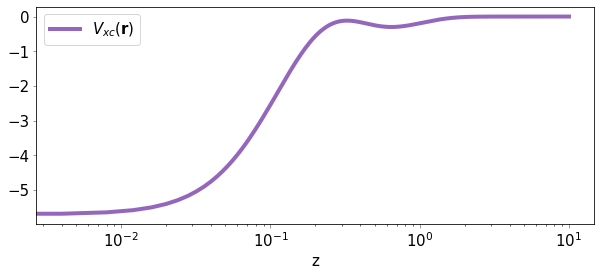

In [35]:
# ZMP

ine.invert(method='zmp', guide_components='fermi_amaldi', lambda_list=np.linspace(10, 1000, 20), opt_max_iter=100, opt_tol=1e-4)
vxc_ne = ine.eng.grid.hartree(density=2*ine.proto_density_a, grid='rectangular',)

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, vxc_ne, lw=4, label="$V_{xc}(\mathbf{r})$", color='tab:purple')
ax.legend(fontsize=15)
ax.set_xlabel('z', fontsize=15)
ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=15, color='grey')
fig.show()


Computing Fermi Amaldi
Optimization Successful within 0 iterations! |grad|=1.07e-04


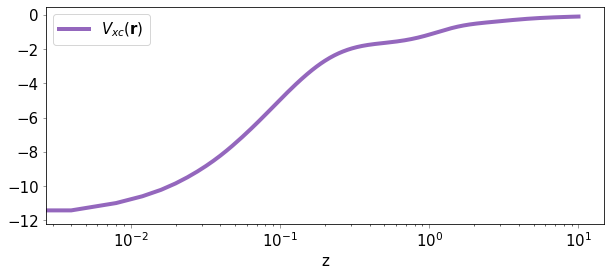

In [36]:
# WY
ine.invert("WuYang", guide_components="fermi_amaldi")

vrest = ine.eng.grid.to_grid(ine.v_pbs, grid='rectangular')
hartree = ine.eng.grid.hartree(da+db, grid='rectangular')
fa = (1-1/(ine.nalpha + ine.nbeta)) * hartree

vxc = fa + vrest - hartree


# Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, vxc, lw=4, label="$V_{xc}(\mathbf{r})$", color='tab:purple')
ax.legend(fontsize=15)
ax.set_xlabel('z', fontsize=15)
ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=15, color='grey')
fig.show()

Computing Fermi Amaldi
Optimization Successful within 1 iterations! |grad|=7.87e-06.


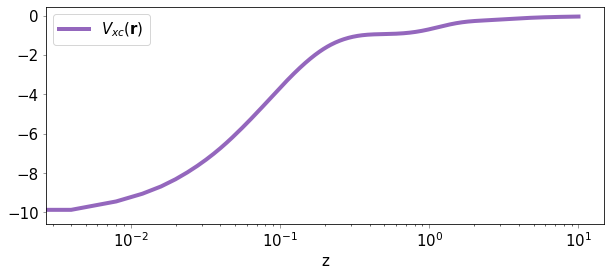

In [37]:
# PEDECO 

ine.invert("PDECO", opt_max_iter=200, guide_components="fermi_amaldi", gtol=1e-6)

vha   = ine.eng.grid.hartree(density = da,  grid='rectangular')
vrest = ine.eng.grid.to_grid(ine.v_pbs, grid='rectangular')
fa = (1-1/(ine.nalpha + ine.nbeta)) * vha
vxc = fa + vrest - vha

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, vxc, lw=4, label="$V_{xc}(\mathbf{r})$", color='tab:purple')
ax.legend(fontsize=15)
ax.set_xlabel('z', fontsize=15)
ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=15, color='grey')
fig.show()